In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import torch_optimizer as optim
# https://github.com/jettify/pytorch-optimizer
# lots of optimisers

In [3]:
import nflows.nn.nets.resnet

In [4]:
from fastprogress.fastprogress import master_bar, progress_bar

from time import sleep
import random

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np

In [7]:
torch.manual_seed(1)    # reproducible

In [91]:

x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 200*0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
# y = 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)


In [92]:
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

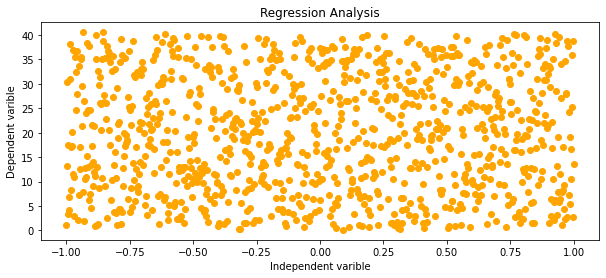

In [93]:

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()


In [94]:
nflows.nn.nets.resnet.ResidualBlock?

Init signature:
nflows.nn.nets.resnet.ResidualBlock(
    features,
    context_features,
    activation=<function relu at 0x13388e830>,
    dropout_probability=0.0,
    use_batch_norm=False,
    zero_initialization=True,
)
Docstring:      A general-purpose residual block. Works only with 1-dim inputs.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/pytorch/lib/python3.7/site-packages/nflows/nn/nets/resnet.py
Type:           type
Subclasses:     


In [95]:
class ResNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, use_batch_norm=True):
        super(ResNet, self).__init__()
        
        self.resnet_stack = torch.nn.Sequential(
            torch.nn.Linear(n_feature, n_hidden),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            nflows.nn.nets.resnet.ResidualBlock(n_hidden, None, use_batch_norm=use_batch_norm),
            torch.nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        return self.resnet_stack(x)

In [96]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(n_feature, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [97]:
def train(net, optimizer, NUM_EPOCHS=100, batch_size=100):


    loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


    ds = TensorDataset(x, y)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
#     loader = DataLoader(ds, batch_size=batch_size, shuffle=False)


    losses = []
    # train the network
    mb = master_bar(range(1, NUM_EPOCHS+1))
    for epoch in mb:
#     for epoch in range(NUM_EPOCHS):
#         loop = tqdm(enumerate(loader), total=len(loader), desc='2nd loop', leave=False)
#         loop = master_bar(enumerate(loader), total=len(loader))
#         loop = master_bar(enumerate(loader), total=len(loader))
        for batch_idx in progress_bar(range(len(loader)), parent=mb):
            (xx, yy) = next(iter(loader))
            
            prediction = net(xx)     # input x and predict based on x
            loss = loss_func(prediction, yy)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward(create_graph=True)         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            losses.append(loss.item())
            
            ### Add the closure function to calculate the gradient.
#             def closure():
#                 if torch.is_grad_enabled():
#                     optimizer.zero_grad()
#                 output = net(xx)
#                 loss = loss_func(output, yy)
#                 if loss.requires_grad:
#                     loss.backward()
#                 return loss
#             optimizer.step(closure)

#             output = net(xx)
#             losses.append(closure())

            
            mb.child.comment = f'batch bar stat'
        mb.main_bar.comment = f'epoch bar stat'

            # add stuff to progress bar in the end
#             loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
#             loop.set_postfix(loss=loss.item())
    #         sleep(0.1)
#             loop.update(1)
#         loop.close(); del loop
    
    return net, losses

In [98]:
def count_parameters(model):
    """
    https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/7
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [99]:
count_parameters(Net(n_feature=1, n_hidden=320, n_output=1))

1644481

In [100]:
count_parameters(ResNet(n_feature=1, n_hidden=320, n_output=1, use_batch_norm=True))

1654721

In [101]:
count_parameters(ResNet(n_feature=1, n_hidden=320, n_output=1, use_batch_norm=False))

1644481

CPU times: user 2min 27s, sys: 52.9 s, total: 3min 20s
Wall time: 2min 27s


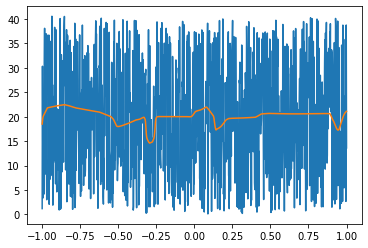

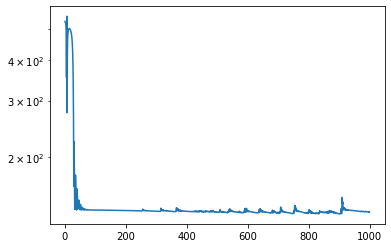

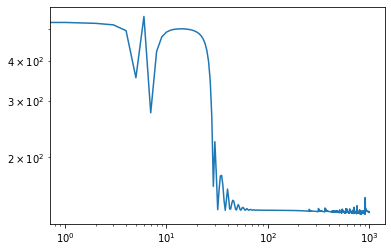

In [102]:
%%time
net = Net(n_feature=1, n_hidden=320, n_output=1)     # define the network
# net = ResNet(n_feature=1, n_hidden=320, n_output=1)     # define the network
# print(net)  # net architecture

optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
# optimizer = torch.optim.AdamW(net.parameters(), lr=0.002)
# optimizer = torch.optim.LBFGS(net.parameters(), lr=0.002)
# optimizer = AdaHessian(net.parameters(), lr=1e-3)
# optimizer = optim.AdamP(net.parameters(), lr=1e-3)
# optimizer = optim.DiffGrad(net.parameters(), lr=1e-3)
# optimizer = optim.QHAdam(net.parameters(), lr=1e-3)
# optimizer = optim.RAdam(net.parameters(), lr=1e-3)
# optimizer = optim.Adahessian(net.parameters(), lr=0.002)


# net, losses = train(net, optimizer=optimizer, NUM_EPOCHS=100000)
# net, losses = train(net, optimizer=optimizer, NUM_EPOCHS=10000, batch_size=100)
net, losses = train(net, optimizer=optimizer, NUM_EPOCHS=1000, batch_size=1000)
# net, losses = train(net, optimizer=optimizer, NUM_EPOCHS=50000, batch_size=20)

# net, losses = train(net, optimizer=optimizer, NUM_EPOCHS=1000, batch_size=20)

plt.figure()
plt.plot(x, y)
plt.plot(x, net(x).detach().numpy())

plt.figure()
plt.plot(losses)
plt.yscale('log')

plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.xscale('log')

CPU times: user 49min 23s, sys: 16min 10s, total: 1h 5min 34s
Wall time: 36min 10s


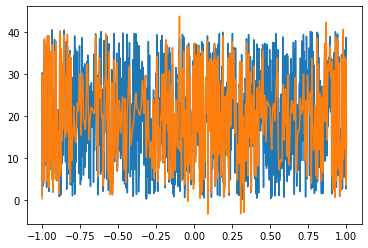

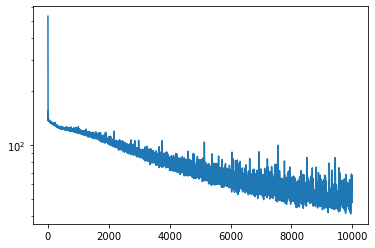

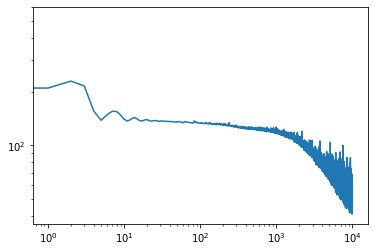

In [109]:
%%time
res_net = ResNet(n_feature=1, n_hidden=320, n_output=1)     # define the network
# print(res_net)  # net architecture

optimizer = torch.optim.Adam(res_net.parameters(), lr=0.002)

res_net, res_net_losses = train(res_net, optimizer=optimizer, NUM_EPOCHS=1000, batch_size=1000)

plt.figure()
plt.plot(x, y)
plt.plot(x, res_net(x).detach().numpy())

plt.figure()
plt.plot(res_net_losses)
plt.yscale('log')

plt.figure()
plt.plot(res_net_losses)
plt.yscale('log')
plt.xscale('log')

CPU times: user 2min 39s, sys: 53.2 s, total: 3min 32s
Wall time: 2min 39s


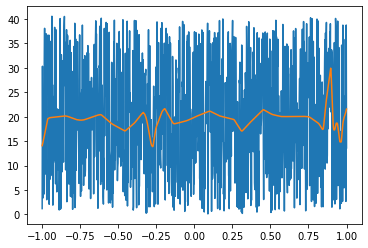

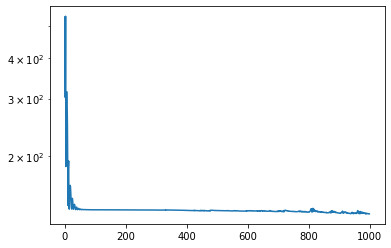

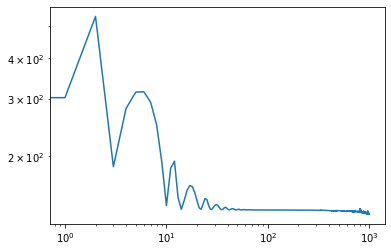

In [104]:
%%time
res_net_bn_false = ResNet(n_feature=1, n_hidden=320, n_output=1, use_batch_norm=False)     # define the network
# print(res_net_bn_false)  # net architecture

optimizer = torch.optim.Adam(res_net_bn_false.parameters(), lr=0.002)

res_net_bn_false, res_net_bn_false_losses = train(res_net_bn_false, optimizer=optimizer, NUM_EPOCHS=1000, batch_size=1000)

plt.figure()
plt.plot(x, y)
plt.plot(x, res_net_bn_false(x).detach().numpy())

plt.figure()
plt.plot(res_net_bn_false_losses)
plt.yscale('log')

plt.figure()
plt.plot(res_net_bn_false_losses)
plt.yscale('log')
plt.xscale('log')

In [105]:
len(losses)

1000

In [106]:
len(res_net_losses)

1000

In [107]:
len(res_net_bn_false_losses)

1000

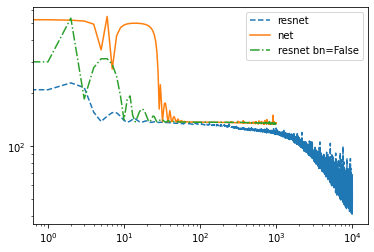

In [112]:
plt.figure()
plt.plot(res_net_losses, ls='--', label='resnet')
plt.plot(losses, label='net')

plt.plot(res_net_bn_false_losses, ls='-.', label='resnet bn=False')

plt.yscale('log')
plt.xscale('log')
plt.legend()

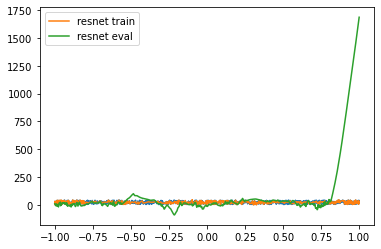

In [148]:
plt.figure()
plt.plot(x, y)
res_net.train()
plt.plot(x, res_net(x).detach().numpy(), label='resnet train')


# need to use res_net.eval() to use model in inference mode
res_net.eval()
plt.plot(x, res_net(x).detach().numpy(), label='resnet eval')

plt.legend()

# plt.xlim(-0.1, 0.1)
# plt.xlim(-1,-0.9)